# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

Импортируем библиотеки

In [2]:
from IPython.display import display

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams

import altair as alt
import seaborn as sns

from random import gauss

In [3]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

Читаем файл

In [4]:
data = pd.read_csv('datasets/real_estate_data.csv', sep = '\t')

### Шаг 2. Предобработка данных

Посмотрим что из мебя представляют наши данные.

In [4]:
data.info()
#display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Замечаем, что в некоторых столбцах отсутствуют значения, а в некоторых тип данных не соответствуют логике. Например - floors_total. Рассмотрим все по порядку. 

ceiling_height - высота потолков (м). Это значение неопределено у более чем 10 тыс. записей. Избавиться от них - явно плохая идея. Нужно чем-то заполнить. Обратимся к статистическим параметрам и гистограмме:

In [5]:
display(data.describe())

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [6]:
def sns_hist(series:pd.Series, title:str, ox_label:str):
    # Визуализация плотности распределения исследуемой величины
    # series - Series с данными исследуемой величины
    # title - Заголовок
    # ox_label - Подпись оси Ох
    plt.figure(figsize=(10,5))
    sns.distplot(series)
    plt.axvline(series.median())
    plt.xlabel(ox_label, fontsize=16)
    plt.ylabel('Плотность', fontsize=16)
    plt.title(title, fontsize=20)
    rcParams['axes.titlepad'] = 0

In [7]:
def sns_hist_log(series, title, ox_label):
    plt.figure(figsize=(10,5))
    sns.distplot(series)
    plt.axvline(series.median())
    plt.xlabel(ox_label, fontsize=16)
    plt.xscale('log')
    plt.ylabel('Плотность', fontsize=16)
    plt.title(title, fontsize=20)
    #rcParams['axes.titlepad'] = 0

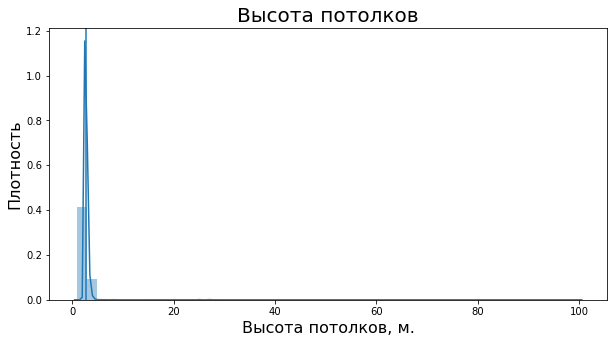

In [8]:
sns_hist(data['ceiling_height'], 'Высота потолков', 'Высота потолков, м.')

Заметим, что значения, в основном лежат в диапазоне 2-4 (При этом половина значений в узком коридоре 2,6-2,7), но есть и единичные выбросы вплоть до 100м. Посмотрим на гистограммы - 2-4 и 4-100.

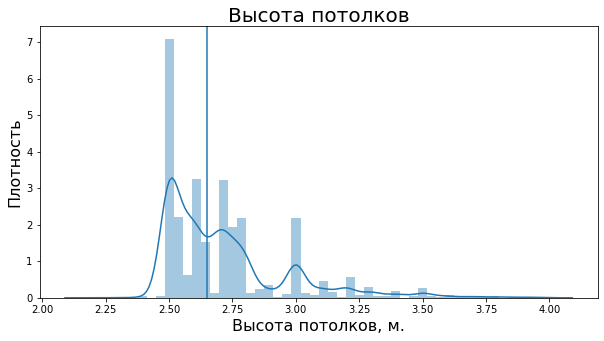

In [9]:
sns_hist(data.query('ceiling_height > 2 and ceiling_height < 4')['ceiling_height'], 'Высота потолков', 'Высота потолков, м.')

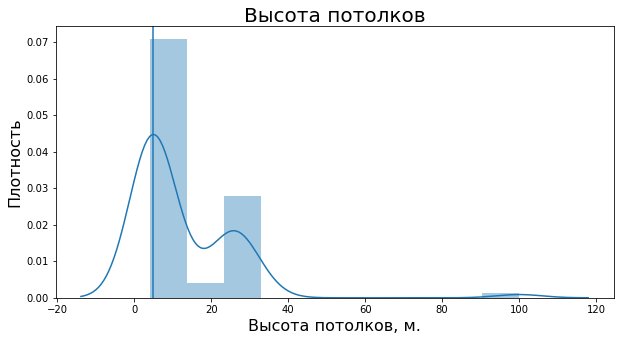

In [10]:
sns_hist(data.query('ceiling_height > 4')['ceiling_height'], 'Высота потолков', 'Высота потолков, м.')

Замечаем, что подавляющее большинство значений находится в логичных рамках 2.4-3.5 м. А единичные выбросы - в большинстве своём начинаются от 3.5 и ниже 2,4 (единичные значения). 
По некоторым из этих значений (свыше 10) - можно предположить, что при вводе значений пользователи ошиблись на 1 порядок (пропустили запятую, например). Позже избавимся от выбросов - оставим только значения в интервале 2,4-3,5. Но предварительно найдем медиану и заполним ей отсутсвующие значения.

In [11]:
ceiling_height_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_median)

Проверим. Выведем повторно гистограмму.

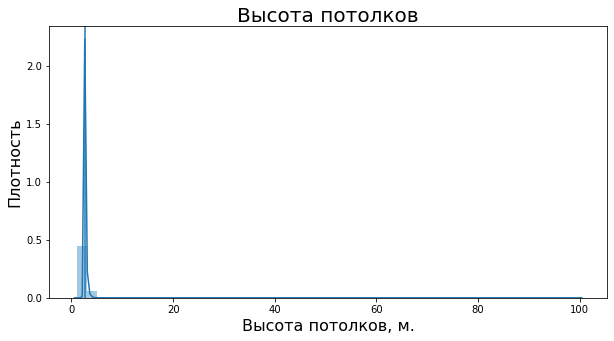

In [12]:
sns_hist(data['ceiling_height'], 'Высота потолков', 'Высота потолков, м.')

Отлично. Всё идеально. Все значения в рамках 2-5.

Перейдем к следующему параметру floors_total - всего этажей в доме. Обратимся к гистограмме.

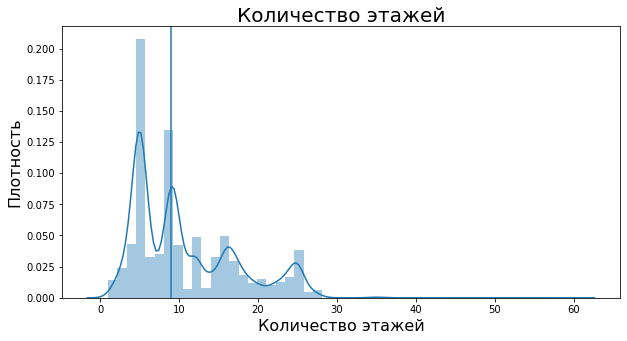

In [13]:
sns_hist(data['floors_total'], 'Количество этажей', 'Количество этажей')

Заметим, что сильно выбивающихся значений нет, а количество пропущенных значений меньше ста, что пренебрежимо мало. Поэтому можем удалить эти значения.

Также приведем значения данного столбца к типу int, предварительно округлив на всякий случай.

In [14]:
data = data.dropna(subset = ['floors_total']).reset_index(drop = True)

In [15]:
data['floors_total'] = data['floors_total'].round()
data['floors_total'] = data['floors_total'].astype('int')

living_area - жилая площадь в квадратных метрах(м²). У нас не хватает около 2000 строк. Этот параметр у нас зависит от total_area. Построим график зависимости жилой площади от общей.

In [16]:
def sns_hist2vars(data:pd.DataFrame, field_x:str, label_x:str, field_y:str, label_y:str):
    # График зависимости двух величин
    # data - DataFrame. Данные для анализа
    # field_x - наименование колонки для исследования по оси Ох
    # label_x - подпись по оси Ох
    # field_y - наименование колонки для исследования по оси Оy
    # label_y - подпись по оси Оy
    plt.figure(figsize=(9,9))
    sns.jointplot(
        x=field_x, 
        y=field_y, 
        data=data, 
        kind="reg", 
        #truncate=False, 
        height=7
    )
    plt.xlabel(label_x, fontsize=16)
    plt.ylabel(label_y, fontsize=16)
   # plt.title(title, fontsize=20)
   # rcParams['axes.titlepad'] = 100 

<Figure size 648x648 with 0 Axes>

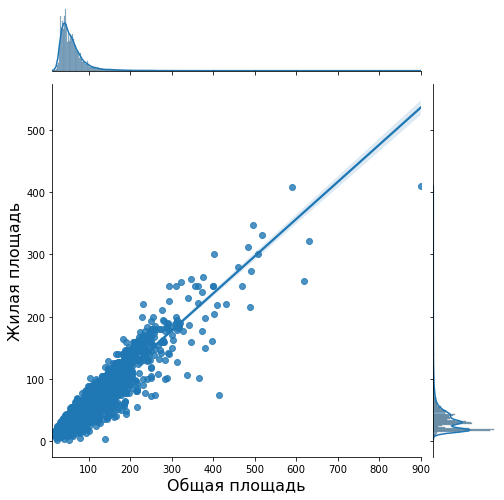

In [17]:
sns_hist2vars(
    data, 
    'total_area', 
    'Общая площадь', 
    'living_area', 
    'Жилая площадь'
)

Заметим, что у нас наблюдается линейная зависимость. Чем больше общая площадь, тем больше и жилая. Это действительно логично и объясняется тем, что размеры кухни, ванной, туалета (кв.метры, которые не входят в жилые) всегда +/- одинаковы (вне зависимости от размеров квартиры). 
Можем заменить отсутствующие значения, на примерные значения функции изображенной на графике. 
Найдем весовой коэффициент - соотношение жилой площади к общей и сохраним в отдельном столбце. На основании общей площади и ~медианы~ **среднего** весового коэффициента рассчитаем и заполним пропущенные значения жилой площади. 

In [18]:
data['living_area_part'] = data['living_area'] / data['total_area']

In [19]:
living_area_part_median = data['living_area_part'].mean()

data['living_area'] = data['living_area'].fillna(data['total_area'] * living_area_part_median)

Сверим график зависимости жилой площади от общей. Картина не изменилась, но пропущенных значений теперь нет.

<Figure size 648x648 with 0 Axes>

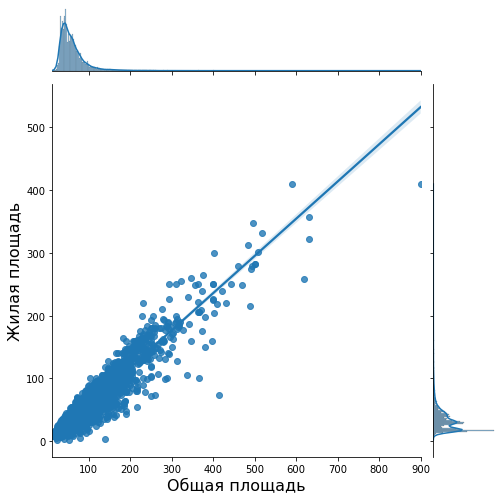

In [20]:
sns_hist2vars(
    data,
    'total_area', 
    'Общая площадь', 
    'living_area', 
    'Жилая площадь'
)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23613 entries, 0 to 23612
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  int32  
 7   living_area           23613 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               12133 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Посмотрим на значения is_apartment - апартаменты (булев тип). Сейчас у нас отрибут имеет тип object. Приведем к типу bool. А также заполним все остальные значения значением по умолчанию 0. Предпологаем, что по умолчанию в нашей выборке данные о жилой недвижимости.

In [22]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [23]:
data['is_apartment'] = data['is_apartment'].fillna(0)
data['is_apartment'] = data['is_apartment'].astype('bool')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23613 entries, 0 to 23612
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  int32  
 7   living_area           23613 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               12133 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

balcony - число балконов. Проверяем значения в выборке. Отклонений нет. Логично предположить, что если количество балконов не указано - значит их количество равно 0. Заменим пропущенные значения на 0. 
А также приведем этот атрибут к типу int. Дробного числа балконов не бывает. На всякий случай, предварительно, округлим значения.

In [25]:
data['balcony'].value_counts()

1.0    4195
0.0    3713
2.0    3657
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

In [26]:
data['balcony'] = data['balcony'].fillna(0)

#data['balcony'] = data['balcony'].round()
data['balcony'] = data['balcony'].astype(pd.Int64Dtype())



locality_name - название населённого пункта. Есть небольшое количество отсутствующих значений, которых лучше удалить. Потому как заполнять их нечем.

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23613 entries, 0 to 23612
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  int32  
 7   living_area           23613 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               23613 non-null  Int64  
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [28]:
data = data.dropna(subset = ['locality_name']).reset_index(drop = True)

kitchen_area - площадь кухни в квадратных метрах (м²).
У нас есть чуть больше 2000 пропущенных значений. Посмотрим гистограмму значений.
Найдём медиану и среднее.

<Figure size 648x648 with 0 Axes>

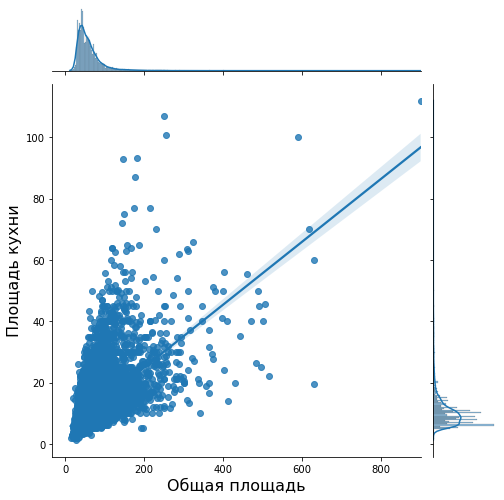

In [29]:
sns_hist2vars(
    data, 
    'total_area', 
    'Общая площадь', 
    'kitchen_area', 
    'Площадь кухни'
)

Заметим, что в отличие от жилой площади - площадь кухни является относительно статичной. На рисунке видны два направления площадей кухни, образуя сектор.
Медиана и среднее тоже отличаются незначительно - можем заменить пропущенные значения на среднее.

In [32]:
#data.plot(y = 'kitchen_rand', x = 'total_area', kind = 'scatter', grid = True, alpha=0.1)

<div style="border:solid orange 2px; padding: 20px"> <b>Что можно улучшить</b><br>
На мой взгляд на рисунке видны два направления площадей кухни -  <a href="http://joxi.ru/BA0qND0hpdyyNr">посмотри подробнее</a>. А комментарий твой <b>площадь кухни является статичной и все значения лежат в одном районе</b> - не совсем корректный, если бы значения площади кухни лежали в одном районе то выглядело бы это примерно так:</div>  

In [30]:
data['kitchen_rand'] = [gauss(20, 0.1) for _ in range(data.shape[0])]

<Figure size 648x648 with 0 Axes>

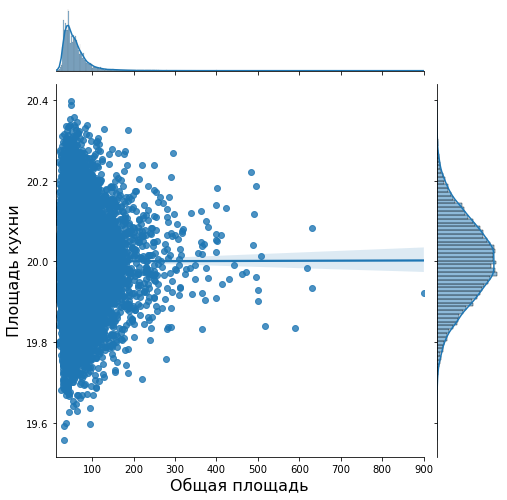

In [31]:
sns_hist2vars(
    data, 
    'total_area', 
    'Общая площадь', 
    'kitchen_rand', 
    'Площадь кухни'
)

<hr style="border: 2px solid orange;" />

In [33]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].mean())

days_exposition — сколько дней было размещено объявление (от публикации до снятия).
У нас есть достачно много (около 3 тыс.) неопределенных значений. Можно предположить, что это те квартиры, которые ещё не успели продать(снять публикацию), поэтому количество дней - неизвестно. Что делать с этими значениями - тоже непонятно. Посмотрим гистограмму, среднее и медиану. 
Приведем также к типу int.

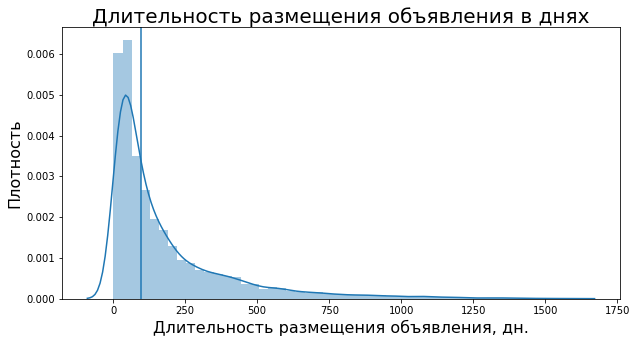

In [34]:
sns_hist(data['days_exposition'], 'Длительность размещения объявления в днях', 'Длительность размещения объявления, дн.')

In [35]:
print('Cколько дней было размещено объявление. Среднее значение - {}'.format(data['days_exposition'].mean()))
print('Cколько дней было размещено объявление. Медиана - {}'.format(data['days_exposition'].median()))

Cколько дней было размещено объявление. Среднее значение - 180.7413945278023
Cколько дней было размещено объявление. Медиана - 95.0


In [36]:
data['days_exposition'] = data['days_exposition'].round()
data['days_exposition'] = data['days_exposition'].astype(pd.Int64Dtype())

В итоге у нас остались данные полученные с помощью картографии. Отсутствие значения в столбцах число парков в радиусе 3 км и число водоемов в радиусе 3 км - можно попробовать объяснить отсутствием парков и водоемов. 

Отсутствующие значения в колонках cityCenters_nearest, airports_nearest, parks_nearest, ponds_nearest можно попробовать объяснить большой удаленностью от ближайшего известного системе аэропорта, парка, водоема, или центра города.

В данном случае лучше оставить всё как есть - потому что у нас нет никаких оснований предпологать те или иные значения вместо отсутствующих.
Единственное только приведем эти значения к типу int. Предварительно округлив значения.

In [37]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].round()
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype(pd.Int64Dtype())

data['airports_nearest'] = data['airports_nearest'].round()
data['airports_nearest'] = data['airports_nearest'].astype(pd.Int64Dtype())

data['parks_nearest'] = data['parks_nearest'].round()
data['parks_nearest'] = data['parks_nearest'].astype(pd.Int64Dtype())

data['parks_around3000'] = data['parks_around3000'].round()
data['parks_around3000'] = data['parks_around3000'].astype(pd.Int64Dtype())

data['ponds_around3000'] = data['ponds_around3000'].round()
data['ponds_around3000'] = data['ponds_around3000'].astype(pd.Int64Dtype())

data['ponds_nearest'] = data['ponds_nearest'].round()
data['ponds_nearest'] = data['ponds_nearest'].astype(pd.Int64Dtype())

Заметим также, что значение цены у нас тоже дробное. И поскольку оно и так очень велико - дробная часть ничего не решает. Логично привести к типу int. Предварительно округлим значения. 

In [38]:
data['last_price'] = data['last_price'].round()
data['last_price'] = data['last_price'].astype(pd.Int64Dtype())

### Вывод

Итак, мы провели предобработку данных. По ряду параметров мы заметили совсем нереальные значения - например для высоты потолков. И заодно провели исследовательский анализ данных и избавились от нестандартных значений. В некоторых столбцах были замечены пропущенные значения. 
Так, для высоты потолков мы заменили их медианой. Для общего количества этажей приняли решение удалить данные - уж очень их было мало. Сведение апартаменты или нет - решили заполнить "нет", исходя из общих соображений. Если количество, балконов указано не было - решили, что скорее всего их нет вообще и заменили значение на 0. Для жилой площади - посчитали среднее соотношение жилой к общей и отталкиваясь от этого заменили пропущенные значения жилой площади. А вот с площадью кухни, мы пришли к выводу, что так не получится. Дом может быть огромным, но при этом кухня в нем будет не сильно отличаться от обычной и приняли решение заменить пропущенные значения средним арифметическим.
По ряду других значений заполнять пропуски проблематичнее. В основном это картографические данные, а также "сколько дней было размещено объявление". Приняли решение оставить всё как есть - очень много значений отсутствует относительно общей выборки.
По ряду атрибутов мы также изменили и тип данных. Апартаменты - да/нет - привели к bool.
Картографические данные - количество водоемов/парков - это натуральные числа - к int.
Картографические данные расстояния - за незначительностью дробной части решили от неё избавиться - к int.
Аналогично и с ценой.



### Шаг 3. Посчитайте и добавьте в таблицу

Посчитаем и добавим в таблицу цену квадратного метра.
Для этого разделим стоимость на общее количество кв.м.

In [39]:
data['sq_m_price'] = data['last_price'] / data['total_area']

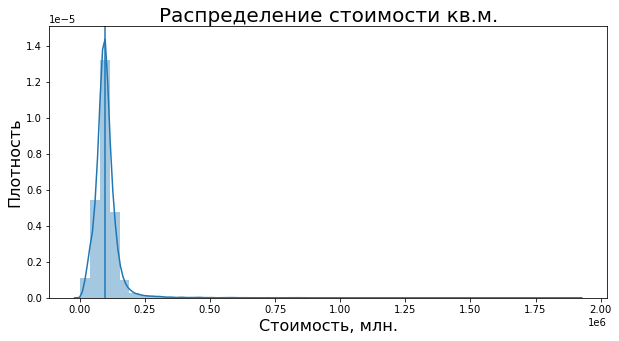

In [40]:
sns_hist(
    data['sq_m_price'], 
    'Распределение стоимости кв.м.', 
    'Cтоимость, млн.'
)

Посчитаем и добавим в таблицу день недели, месяц и год публикации объявления.
Для начала приведем колонку first_day_exposition к типу данных datetime.

In [41]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [42]:
data['year_exposition'] = data['first_day_exposition'].dt.year
data['month_exposition'] = data['first_day_exposition'].dt.month
data['day_exposition'] = data['first_day_exposition'].dt.day

Определим день недели:

In [43]:
data['dayofweek'] = data['first_day_exposition'].dt.weekday

Определим тип этажа — первый, последний, другой. Для этого напишем функцию и применим её к нашему датасету

In [44]:
def get_floortype(row):
    try:
        if row['floor'] == row['floors_total'] and row['floors_total'] != 1:
            return 'последний'
        if row['floor'] == 1:
            return 'первый'
        return 'другой'
    except:
        return 'ошибка вычисления'     

data['floortype'] = data.apply(get_floortype, axis = 1)

In [45]:
data['floortype'].value_counts()

другой       17326
последний     3330
первый        2909
Name: floortype, dtype: int64

Найти соотношение жилой и общей площади, а также отношение площади кухни к общей.
Отношение жилой к общей мы нашли ранее. Найдем теперь отношение площади кухни к общей.

Поскольку остались пропущенные значения в living_area_part с предыдущего раза - пересчитаем их ещё раз.

In [46]:
data['kitchen_area_part'] = data['kitchen_area'] / data['total_area']
data['living_area_part'] = data['living_area'] / data['total_area']

### Вывод

Мы посчитали и добавили в таблицу цену квадратного метра. Для этого разделили стоимость на общее количество кв.м. Посчитали и добавили в таблицу день недели, месяц и год публикации объявления. Предварительно привели колонку first_day_exposition к типу данных datetime. Определили тип этажа — первый, последний, другой. Нашли соотношение жилой и общей площади, а также отношение площади кухни к общей. 

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

In [47]:
display(data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,living_area_part,kitchen_rand,sq_m_price,year_exposition,month_exposition,day_exposition,dayofweek,floortype,kitchen_area_part
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,<NA>,0.472222,19.960806,120370.370370,2019,3,7,3,другой,0.231481
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,81,0.460396,20.060873,82920.792079,2018,12,4,1,первый,0.272277
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,558,0.612500,20.164813,92785.714286,2015,8,20,3,другой,0.148214
3,0,64900000,159.00,2015-07-24,3,2.65,14,89.826726,9,False,...,424,0.564948,19.907823,408176.100629,2015,7,24,4,другой,0.066421
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,121,0.320000,19.931630,100000.000000,2018,6,19,1,другой,0.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23560,9,9700000,133.81,2017-03-21,3,3.70,5,73.300000,3,False,...,<NA>,0.547792,20.053164,72490.845228,2017,3,21,1,другой,0.103356
23561,14,3100000,59.00,2018-01-15,3,2.65,5,38.000000,4,False,...,45,0.644068,19.969491,52542.372881,2018,1,15,0,другой,0.144068
23562,18,2500000,56.70,2018-02-11,2,2.65,3,29.700000,1,False,...,<NA>,0.523810,20.071996,44091.710758,2018,2,11,6,первый,0.186261
23563,13,11475000,76.75,2017-03-28,2,3.00,17,43.359756,12,False,...,602,0.564948,19.957410,149511.400651,2017,3,28,1,другой,0.303583


### Изучим параметры

Изучим параметр площадь. Построим гистограмму и посмотрим статистические данные.

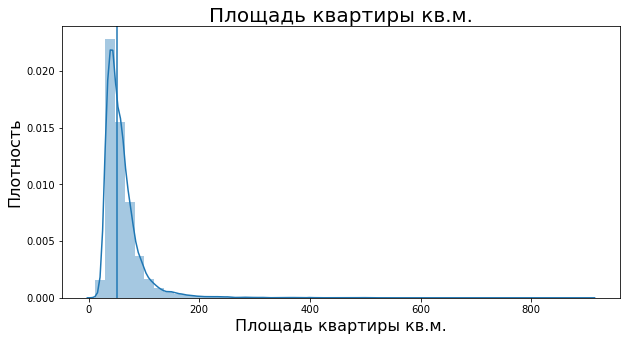

In [48]:
sns_hist(
    data['total_area'], 
    'Площадь квартиры кв.м.', 
    'Площадь квартиры кв.м.'
)

Если прикинуть в уме ящик с усами - выбросы начинаются с третьего квартиля + полтора межквартильных размаха, то получим, что выбросы начинаются где-то со 105 кв.м. И мы видим, что подавляющее большинство значений лежит в промежутке от 0 до 200 (дальше гистограмма начинает сливаться с "землей"). А чем выше площадь - тем меньше таких значений. Свыше 400 м - таких предложений вообще единицы.
Для репрезентативности построим гистограмму на интервале 0-200 с количеством корзин 20 (через каждые 10 кв.м.).
Заодно построим "ящик с усами" в диапазоне 0-200.

<div style="border:solid orange 2px; padding: 20px"> <b>Что можно улучшить</b><br>
А чего прикидывать,  можно же посчитать =)</div> 

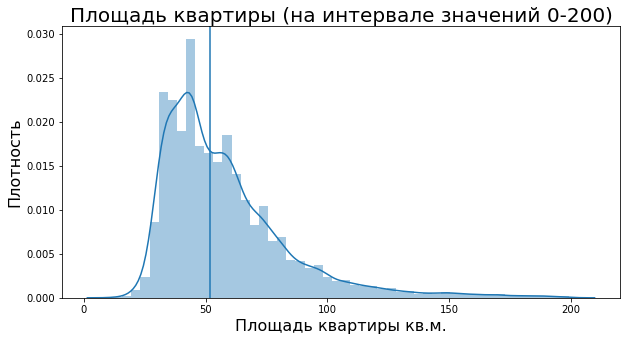

In [49]:
sns_hist(
    data.query('total_area < 200')['total_area'], 
    'Площадь квартиры (на интервале значений 0-200)', 
    'Площадь квартиры кв.м.'
)

In [50]:
def sns_hist_boxplot(data, ox_field, ox_label, title):
    series = data[ox_field]
    figsize=(12,7)
    
    #plt.figure(figsize=figsize)
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)}, figsize=figsize)
    #plt.title(title, fontsize=20)
    
    sns.boxplot(x=ox_field, data=data, width=0.8, ax = ax_box, palette = 'pastel')
    
    sns.distplot(series, ax = ax_hist)
    plt.axvline(series.median())
    
    ax_box.set_xlabel(ox_label + ' (boxplot)', fontsize=12)
    ax_hist.set_xlabel(ox_label, fontsize=12)
    plt.ylabel('Плотность', fontsize=16)
    plt.suptitle(title, fontsize=18)
    #rcParams['axes.titlepad'] = 0

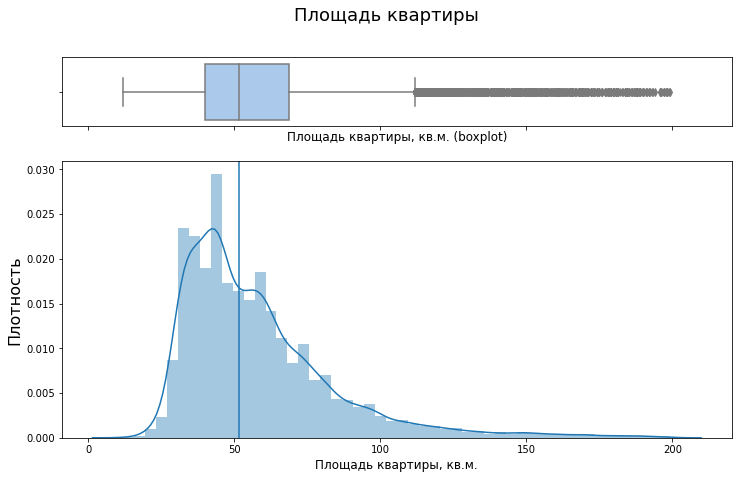

In [51]:
sns_hist_boxplot(data.query('total_area < 200'), 'total_area', "Площадь квартиры, кв.м.", "Площадь квартиры")

In [52]:
#data_total_area = data.query('total_area < 200')[['total_area']]
#data_total_area.boxplot() 
#plt.ylim(-10, 210)
#plt.title("Площадь квартиры")
#plt.ylabel("Площадь квартиры, кв.м.")

Ожидаемо, наблюдаем пик в районе 30-40 и 40-50 кв.м. и дальше значения идут на спад. А также логично отсутствие квартир до 10 кв.м. и совсем небольшое их количество в районе 10-20 кв.м. и 20-30 кв.м.(относительно).
По гистограмме можно считать значения выше 130 - выбросами. Уж очень мало значений идёт в каждой корзине дальше.

<div style="border:solid orange 2px; padding: 20px"> <b>Что можно улучшить</b><br>
Можно попробовать совместить оба графика - для быстроты оценки отличный вариант👌</div> 

In [53]:
# функция для отображения гистограммы и боксплота
def histbox(values, figsize=(9, 6), title=None, bins=11, xlabel=None, whis=1.5, 
            flierprops=dict(markerfacecolor='r', marker='s'), boxprops=dict(color='white'), whiskerprops=dict(color='#FFC358'), xlim=None, **kwargs):
    # Построение гистограммы
    fig, ax1 = plt.subplots(figsize=figsize)
    plt.title(title)
    ax1.hist(values, bins=bins, label='Гистограмма', **kwargs)
    ax1.set_xlabel(xlabel)
    ax1.legend()
    ax1.set_xlim(xlim)
    ax1.grid(True, color='grey', linestyle='-', linewidth=0.25)
    ax2 = ax1.twinx()
    
    ax2.boxplot(values, vert=False, whis=whis, notch=True, capprops=whiskerprops, 
                flierprops=flierprops, boxprops=boxprops, whiskerprops=whiskerprops)
    ax2.set_xlim(xlim)
    plt.show()

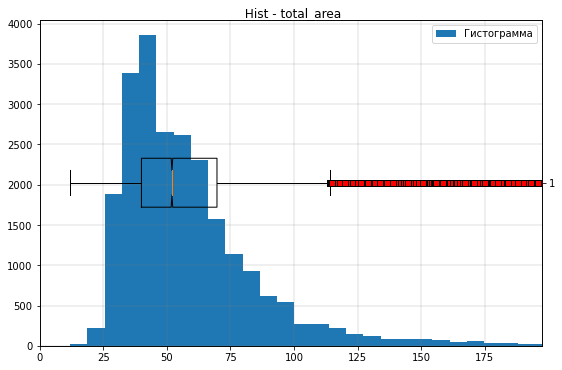

In [54]:
histbox(data['total_area'], bins=131, boxprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        title=" Hist - total_area", xlim=(0, data['total_area'].quantile(0.99)))



<hr style="border: 2px solid orange;" />

Изучим параметр количество комнат.

In [55]:
def alt_value_counts(df:pd.DataFrame, col:str, title:str):
    # Функция для отображения уникальных значений столбца и общего количества значений по каждому уникальному значению
    # df - DataFrame. Данные для анализа
    # col - наименование колонки, информацию о которой необходимо отобразить.
    # title - Заголовок графика
    series_info = df.groupby(col)[col].count()
    data_info = pd.DataFrame({col:series_info.index, 'Количество':series_info.values})
    
    bars = alt.Chart(data_info, title = title).mark_bar().encode(
        x='Количество:Q',
        y=col + ":O"
    )

    text = bars.mark_text(
        align='left',
        baseline='middle',
        dx=3  # Nudges text to right so it doesn't appear on top of the bar
    ).encode(
        text='Количество:Q'
    )

    return (bars + text).properties(height = len(series_info) * 20)

In [56]:
#sns_hist(data['rooms'], 'Количество комнат', 'Количество комнат')

alt_value_counts(data, 'rooms', 'Количество комнат')

alt.LayerChart(...)

Огромное количество наблюдений для 1, 2, 3 комнатных квартир. Гораздо меньше 4, 5 и 0 комнат. Остальные - очень редкие, выбивающиеся значения. Будем считать выбросами значения 6 и выше.

Высоту потолков мы уже анализировали ранее и отсеяли тогда совсем невероятные значения. Разберемся сейчас какие значения мы можем не учитывать.

In [57]:
print(data['ceiling_height'].describe())

count    23565.000000
mean         2.724530
std          0.991026
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


In [58]:
alt_value_counts(data, 'ceiling_height', 'Высота потолков')

alt.LayerChart(...)

Изучите параметр цена. Найдем среднее и медиану. Построим гистограмму.

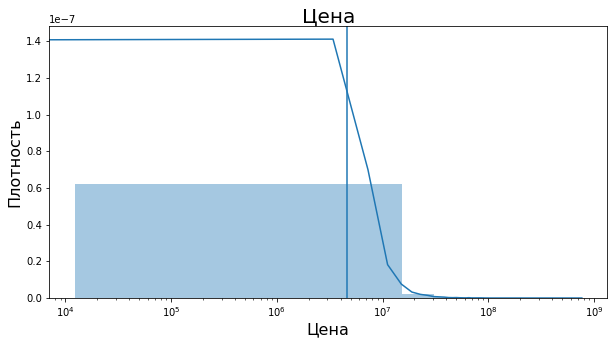

In [59]:
sns_hist_log(data['last_price'], 'Цена', 'Цена')

В основном цены лежат в промежутке 0 - 5х10^7. Посмотрим гистограмму на этом промежутке. Но анализировать это трудно. Если отталкиваться от "ящика с усами" и межквартильным размахом. То выбросы начинаются с примерно 1,3х10^7. Построим гистограмму на интервале 0 - 5*10^7. И ящик с усами.

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  Int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

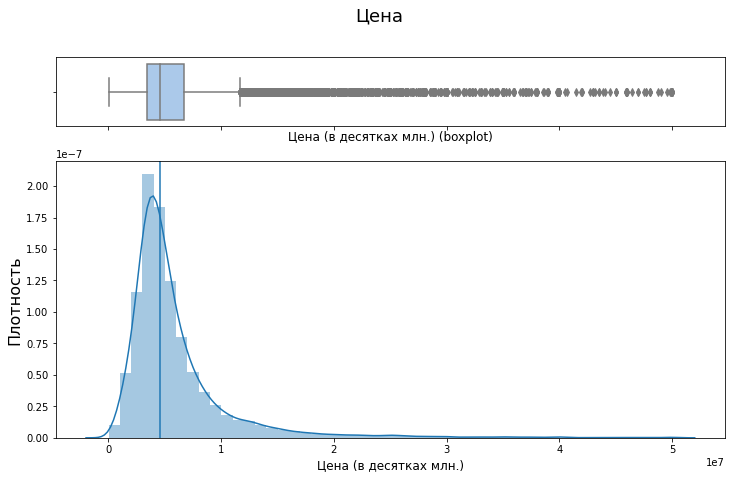

In [61]:
sns_hist_boxplot(data[data['last_price'] <= 50000000], 'last_price', 'Цена (в десятках млн.)', 'Цена')


Да, действительно ус заканчивается в районе 1,2*10^7. А по гистограмме начиная с 2х10^7 график превращается в тонкую линию, которая потом и вовсе начинает прерываться. Определим нормальные значения до 2х10^7.

### Изучим время продажи

Изучите время продажи квартиры. Найдем медиану, среднее. Посмотрим общие статистические параметры. Построим гистограмму и диаграмму размаха.

In [62]:
print('Цена. Среднее значение - {}'.format(data['days_exposition'].mean()))
print('Цена. Медиана - {}'.format(data['days_exposition'].median()))
data['days_exposition'].describe()

Цена. Среднее значение - 180.7413945278023
Цена. Медиана - 95.0


count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  Int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

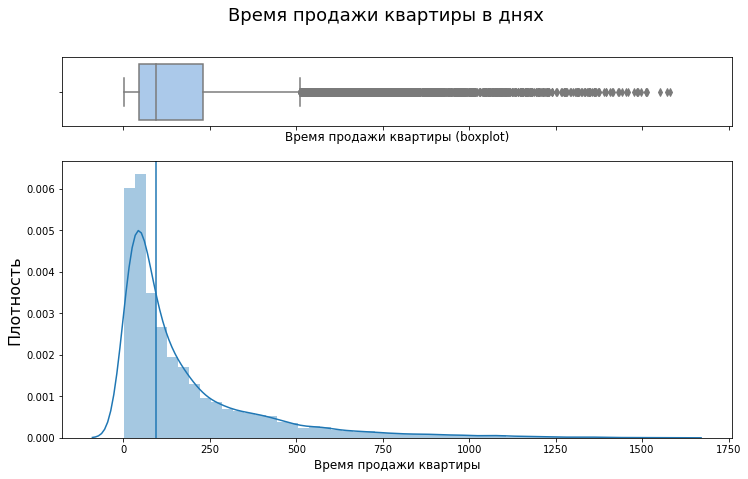

In [64]:
sns_hist_boxplot(data[data['days_exposition'] == data['days_exposition']], 'days_exposition', 'Время продажи квартиры', 'Время продажи квартиры в днях')

По гистограмме - подавляющее количество значений находится в районе до 200 дней. Это же подтверждают медиана и среднее врифметическое 95 и 180. По "ящику с усами" определяем, что выбросы начинаются с 500 (примерно). По гистограмме - начиная с 600 дней видим очень малое количество наблюдений. Построим ещё гистограмму на промежутке 0-600.

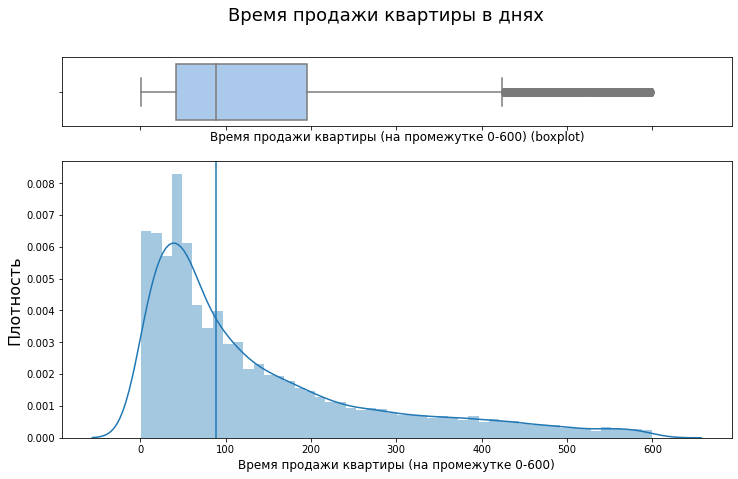

In [65]:
sns_hist_boxplot(
    data[data['days_exposition'] <= 600], 
    'days_exposition', 
    'Время продажи квартиры (на промежутке 0-600)', 
    'Время продажи квартиры в днях'
)

Можем сделать следующий вывод: Если продажа прошла за 100 дней и менее - значит продажа прошла очень быстро, а выше 600 - очень долго.

### Уберем редкие и выбивающиеся значения

Уберем полученные редкие и выбивающиеся значения. Сохраним новые данные в новой переменной data_new.
Итак, мы определили, что нормальные значения таковы:
Высота потолков от 2,4 до 3,5.
Общая площадь - 0-130
Число комнат - 0-5
Цена - 0-2*10^7
Время продажи квартиры - 0-600.


In [66]:
data['ceiling_height'].describe([0.75, 0.8, 0.9])

count    23565.000000
mean         2.724530
std          0.991026
min          1.000000
50%          2.650000
75%          2.700000
80%          2.750000
90%          3.000000
max        100.000000
Name: ceiling_height, dtype: float64

<hr style="border: 2px solid orange;" />

In [67]:
data_new = data
data_new = data_new.query('ceiling_height >= 2.4 and ceiling_height <= 3.5')
data_new = data_new.query('total_area <= 130')
data_new = data_new.query('rooms <= 5')
data_new = data_new[data_new['last_price'] <= 20000000]
data_new = data_new[data_new['days_exposition'] <= 600]
data_new = data_new.reset_index(drop = True)

In [68]:
print('Количество записей до {}'.format(data.shape[0]))
print('Количество записей после {}'.format(data_new.shape[0]))

print('Избавились от', round((1 - data_new.shape[0]/data.shape[0]) * 100, 2), '% первоначальных данных' )

Количество записей до 23565
Количество записей после 18355
Избавились от 22.11 % первоначальных данных


За счёт удалений наша выборка сократилась на 5 тыс. наблюдений. Это достаточно много, конечно, но с грязными данными работать - куда более неэффективно.

### Какие факторы больше всего влияют на стоимость квартиры?

Изучим какие факторы больше всего влияют на стоимость квартиры.

Начнем с зависит ли цена от площади? Построим график. 

In [69]:
data_new['last_price_10e7'] = data_new['last_price'] / 10000000

<Figure size 648x648 with 0 Axes>

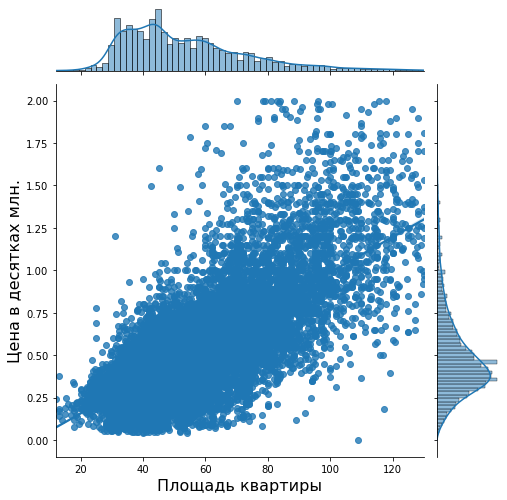

In [70]:
sns_hist2vars(data_new, 'total_area', 'Площадь квартиры', 'last_price_10e7', 'Цена в десятках млн.')

Получили этакое облако. Которое вытягивается "вверх и вправо", что означает, что с увеличением общей площади увеличивается и стоимость.

Зависит ли цена от количества комнат? Построим график. 

<Figure size 648x648 with 0 Axes>

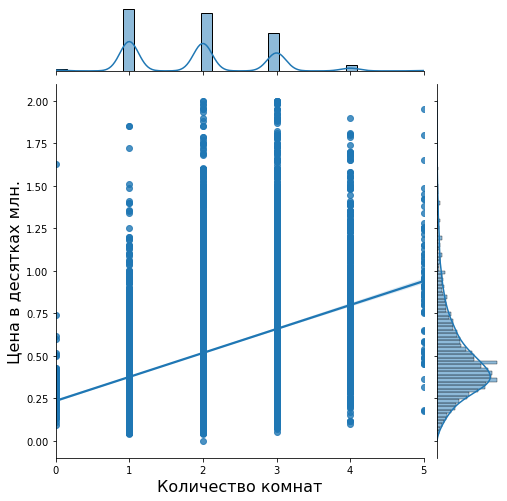

In [71]:
sns_hist2vars(data_new, 'rooms', 'Количество комнат', 'last_price_10e7', 'Цена в десятках млн.')


По этому графику Можно также сказать, что цена зависит от количества комнат. С увеличением числа комнат "низ" шкалы поднимается чуть выше (хорошо видно в сравнении 2 и 3 или 3 и 4). Точно так же и "верх" шкалы. Значений 4 и 5 очень мало, поэтому здесь они "растворяются". Специально сделали график таким, чтобы размыть большое количество наблюдений для 1-2-3 комнат. 

Cтарт цен для 5 комнат - гораздо выше даже относительно 4 комнат. А низ 4-хкомнатных выше 3-х. Верх графика оценивать нужно с поправкой на отсеченные данные и относительно малое количество 4-5 комнатных квартир относительно трешек и двушек.

Зависит ли цена от удаленности от центра? Построим график. 

In [72]:
data_new['cityCenters_nearest_km'] = data_new['cityCenters_nearest'] / 1000

<Figure size 648x648 with 0 Axes>

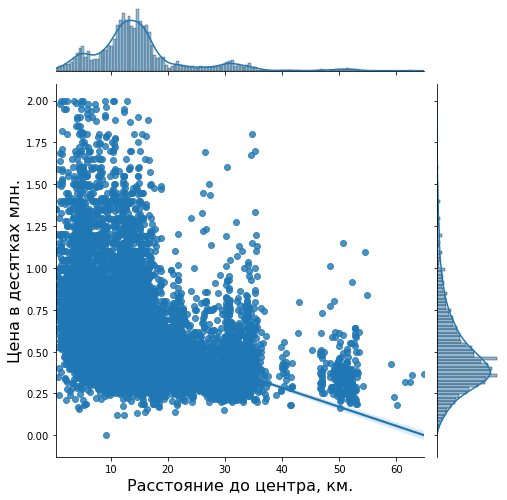

In [73]:
sns_hist2vars(data_new, 'cityCenters_nearest_km', 'Расстояние до центра, км.', 'last_price_10e7', 'Цена в десятках млн.')

Снова получили облако, которое вытягивается "вверх и влево", что означает, что чем ближе к центру - тем выше стоимость.

Зависит ли цена от типа этажа? Построим сводную таблицу со значениями медианы и среднего арифм. Найдем медиану и среднее в общем и сравним отношения каждого типа к общему.

In [74]:
data_floor2price = data_new.pivot_table(index='floortype', values='last_price', aggfunc=['median', 'mean'])

median_price = data_new['last_price'].median()

mean_price = data_new['last_price'].mean()

data_floor2price.columns = ['медиана цены', 'ср.арифм. цены']

data_floor2price['отношение к общей медиане'] = data_floor2price['медиана цены'] / median_price
data_floor2price['отношение к общему ср.арифм'] = data_floor2price['ср.арифм. цены'] / mean_price

display(data_floor2price)

,медиана цены,ср.арифм. цены,отношение к общей медиане,отношение к общему ср.арифм
floortype,,,,
другой,4550000,5.279878e+06,1.034091,1.043149
первый,3750000,4.098006e+06,0.852273,0.809645
последний,4070000,4.722959e+06,0.925000,0.933118


Как видим зависимость есть. И по медиане и по среднему. Так в среднем первые этажи дешевле на 15-20%. А последние - на 7-8. Относительно средних показателей.

Первые этажи, обычно, самые дешевые. Последние чуть дороже, но всё равно дешевле остальных.

Изучим зависимость от даты размещения по году/месяцу/дню недели. Построим сводные таблицы.

In [75]:
data_year2price = data_new.pivot_table(index='year_exposition', values='last_price', aggfunc=['median', 'mean'])
data_year2price.columns = ['медиана цены', 'ср.арифм. цены']
display(data_year2price)

,медиана цены,ср.арифм. цены
year_exposition,,
2014,6390000,6.856179e+06
2015,4700000,5.309382e+06
2016,4300000,5.095957e+06
2017,4320000,5.069990e+06
2018,4400000,4.995794e+06
2019,4700000,5.223678e+06


In [76]:
data_month2price = data_new.pivot_table(index='month_exposition', values='last_price', aggfunc=['median', 'mean'])
data_month2price.columns = ['медиана цены', 'ср.арифм. цены']
display(data_month2price)

,медиана цены,ср.арифм. цены
month_exposition,,
1,4400000,5.021131e+06
2,4400000,5.057194e+06
3,4300000,4.977652e+06
4,4490000,5.108972e+06
5,4399000,5.080310e+06
6,4200000,4.945696e+06
7,4350000,5.009639e+06
8,4400000,5.119870e+06
9,4500000,5.297679e+06


In [77]:
data_dayofweek2price = data_new.pivot_table(index='dayofweek', values='last_price', aggfunc=['median', 'mean'])
data_dayofweek2price.columns = ['медиана цены', 'ср.арифм. цены']
display(data_dayofweek2price)

,медиана цены,ср.арифм. цены
dayofweek,,
0,4385000,5.035310e+06
1,4450000,5.129982e+06
2,4400000,5.040608e+06
3,4400000,5.128287e+06
4,4350000,5.057917e+06
5,4400000,4.977264e+06
6,4300000,4.931271e+06


Заметим, что в 2014-м году квартиры стоили гораздо дороже. После чего цены до сих пор остаются на +/- одном и том же уровне. Можно связать эту закономерность с падением курса рубля и соответствующим снижением уровня жизни.

По месяцам - всё ровненько, никаких выбросов. Значения медианы в районе 4.2-4.5кк, ср.арифм. - 4.9-5.3кк.
Аналогичная ситуация и по дням недели.
Всё в пределах допустимой погрешности.

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
def make_box_by_category(value=None, category=None, data=None, sort=False, sort_by=None, stat='median', title='', **kwargs):
    """
    value: боксплоты для каких значений строить
    category: группирующая переменная
    data: данные
    sort: сортировка, False = ascending
    sort_by: по какому полю сортировать, возможный выбор value или category
    stat: расчетная статистика  - mean/median
    title: заголовок графика
    """
    #сортировка по stat
    tmp = \
        data\
        .groupby(category, as_index=False)\
        .agg({value:stat})\
        .sort_values(by=sort_by, ascending=sort).reset_index()

    plt.figure(figsize=(9,6))
    sns.boxplot(x=category, y= value, data=data, showfliers=False, order=tmp[category].to_list(), 
                showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, **kwargs)
    plt.title(title)
    plt.grid(True)
    plt.show()

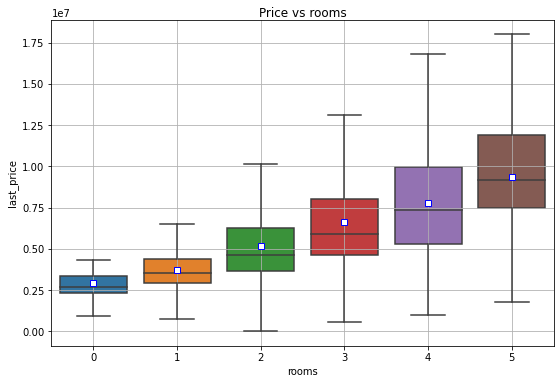

In [79]:
make_box_by_category(value='last_price', category='rooms', data=data_new, sort=True,
                     sort_by='rooms', title='Price vs rooms')

<hr style="border: 2px solid orange;" />

### Исследуем 10 населённых пунктов с наибольшим числом объявлений. 

Выберем 10 населённых пунктов с наибольшим числом объявлений. Проанализируем их.

In [80]:
series_top10locality = data_new.groupby('locality_name')['locality_name'].count().sort_values(ascending = False).head(10)

data_top10locality = pd.DataFrame({'locality_name':series_top10locality.index, 'count':series_top10locality.values})

display(data_top10locality)

,locality_name,count
0,Санкт-Петербург,11975
1,посёлок Мурино,493
2,посёлок Шушары,392
3,Всеволожск,314
4,Колпино,298
5,посёлок Парголово,292
6,деревня Кудрово,276
7,Пушкин,272
8,Гатчина,246
9,Выборг,189


Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Добавим колонку средней стоимости кв.м. в таблицу топ-10 населенных пунктов, которую получили ранее. Отсортируем её по стоимости кв.м. и выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья.

In [81]:
series_locality2sq_m_price = data_new.groupby('locality_name')['sq_m_price'].mean()
data_locality2sq_m_price = pd.DataFrame({'locality_name':series_locality2sq_m_price.index, 'sq_m_price':series_locality2sq_m_price.values})
data_top10locality = data_top10locality.merge(data_locality2sq_m_price, on = 'locality_name')

In [82]:
display(data_top10locality.sort_values(by = 'sq_m_price', ascending = False))

,locality_name,count,sq_m_price
0,Санкт-Петербург,11975,106954.214073
7,Пушкин,272,100588.512514
6,деревня Кудрово,276,92706.652317
5,посёлок Парголово,292,89472.350768
1,посёлок Мурино,493,85857.203715
2,посёлок Шушары,392,77799.347429
4,Колпино,298,74607.410293
8,Гатчина,246,68344.849250
3,Всеволожск,314,66753.079962
9,Выборг,189,57225.208927


Из полученной нами выборки получаем, что самое дорогое жильё - в Санкт-Петербурге, а самое дешевое в Выборге.

### Изучим Санкт-Петербург

Изучим предложения из Санкт-Петербурга. Задача — выяснить, какая область входит в центр. Для этого сохраним необходимые данные в переменной data_spb. Создадим в ней столбец - расстояние в км. И рассчитаем среднее для каждого километра.

In [83]:
data_spb = data_new.query('locality_name == "Санкт-Петербург"').reset_index(drop = True)

data_spb['cityCenters_nearest_km'] = (data_spb['cityCenters_nearest'] / 1000).round()
data_spb['cityCenters_nearest_km'] = data_spb['cityCenters_nearest_km'].astype(pd.Int64Dtype())

In [84]:
series_spb_center = data_spb.groupby('cityCenters_nearest_km')['sq_m_price'].mean()
data_spb_center =  pd.DataFrame({'cityCenters_nearest_km':series_spb_center.index, 'sq_m_price':series_spb_center.values})

Построим график зависимости цены от расстояния до центра города.

In [85]:
data_spb_center['sq_m_price_10e5'] = data_spb_center['sq_m_price'] / 100000

In [86]:
def sns_lineplot(data, field_x, field_y, label_x, label_y):
    # График по точкам
    # data - Данные
    # field_x - наименование колонки для исследования по оси Ох
    # field_y - наименование колонки для исследования по оси Оy
    # label_x - подпись по оси Ох
    # label_y - подпись по оси Оy
    
    plt.figure(figsize=(10,5))
    sns.lineplot(data=data, x=field_x, y=field_y, markers=True, dashes=False, palette = 'pastel')
    plt.xlabel(label_x, fontsize=16)
    plt.ylabel(label_y, fontsize=16)

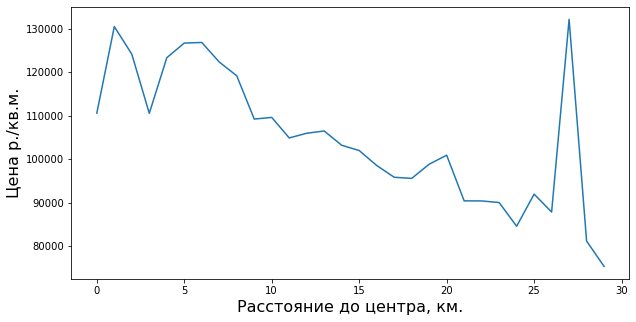

In [87]:
sns_lineplot(data_spb_center, 'cityCenters_nearest_km', 'sq_m_price', 'Расстояние до центра, км.', 'Цена р./кв.м.')

По графику виден резкий спад цен на восьмом километре от центра. Значит квартирами в центре города будем считать квартиры в радиусе 8 км.

График получился неидеальным, в некоторых местах скачкообразным. Так, например, есть необъяснимые небольшие "завалы" на 0-м и третьем километре от центра, а также пик на 27 километре. Как вариант это можно объянить небольшим количеством наблюдений в данных корзинах и, соответственно, большим удельным весом каждого наблюдения.

Но в целом виден тренд на снижение цены на квартиры с удалением от центра. 
Если в центре это около 130 тыс./кв.м., то в 20-25 км. от центра это значение уже в полтора раза меньше

### Изучим центр Санкт-Петербурга

Выделим сегмент квартир в центре. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков.

In [88]:
data_center = data_spb[data_spb['cityCenters_nearest_km'] <= 8].reset_index(drop = True)
#data_center = data_spb.query('cityCenters_nearest_km <= 8').reset_index(drop = True)

Оценим параметр площадь. Сравним с выборкой по всему городу.

In [90]:
def SideBySideHist(series_1:pd.Series, series_2:pd.Series, title:str, ox_label:str, legend:list, figsize:tuple=(11,6), bins = 20):
    """
    Функция выводящая сравнение распределений двух наборов данных
    series_1: первый набор данных, который участвует в сравнении
    series_2: второй набор данных, который участвует в сравнении
    title: заголовок
    ox_label: подпись оси Ox
    legend: легенда
    """
    plt.figure(figsize=figsize)
    sns.histplot(series_1, color = '#f8d568', kde=True, stat = 'probability', bins=bins)
    sns.histplot(series_2, color = '#18a7b5', kde=True, stat = 'probability', bins=bins)
    
    plt.axvline(series_1.median(), color = '#f8d568')
    plt.axvline(series_2.median(), color = '#18a7b5')
    
    plt.ylabel('Плотность', fontsize=14)
    plt.xlabel(ox_label, fontsize=16)
    plt.legend(legend, fontsize=18)
    plt.title(title, fontsize=20)

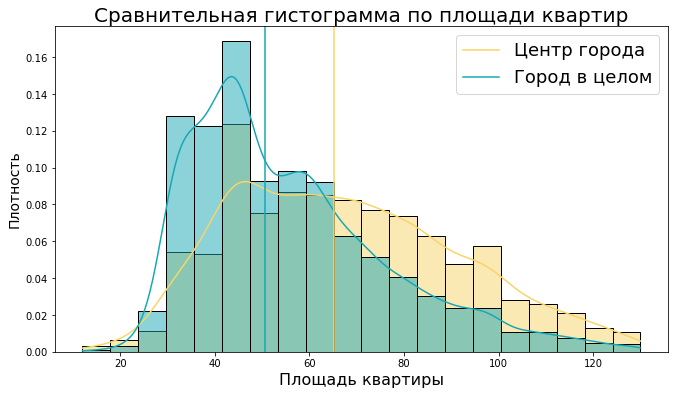

In [91]:
SideBySideHist(
    data_center['total_area'], 
    data_spb['total_area'], 
    'Сравнительная гистограмма по площади квартир',
    'Площадь квартиры', 
    ['Центр города', 'Город в целом']
    )

Заметим, что в общем по городу преобладает группа 30-50 кв.м. Чуть поменьше - группа 50-70(80). В то время, как в центре, за исключением пика в районе 40-50, значения распределены +/- равномерно на промежутке от 30 и аж до 100 кв.м.

Можно выдвинуть гипотезу, что за центром города - продается более однотипное жильё, со стандартным набором кв.м. (в большинстве своём). 

Посмотрим следующее параметры. Цена.

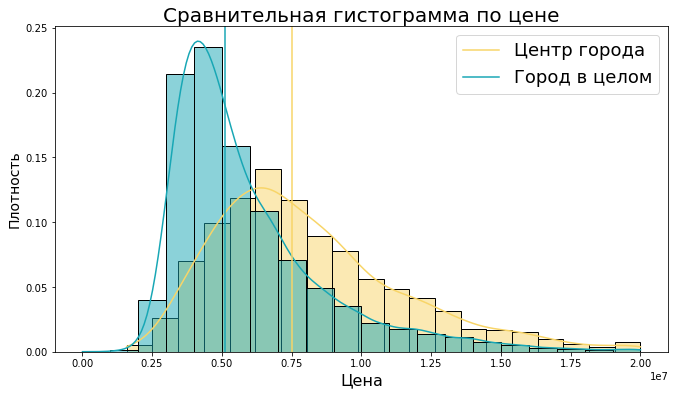

In [92]:
#SidebySideHist('last_price', 'last_price', 'Цена', 'Количество наблюдений', 'Сравнительная гистограмма по цене')

SideBySideHist(
    data_center['last_price'].astype(float), 
    data_spb['last_price'].astype(float), 
    'Сравнительная гистограмма по цене',
    'Цена', 
    ['Центр города', 'Город в целом']
    )


Замечаем, что в центре немного смещен "пик" встречаемости цен. Если в общем по городу чаще всего можно встретить предложения 3-5 млн. То уже в центральной части - это значение 6-7 млн. Что подтверждает теорию о том, что чем ближе к центру тем дороже квартиры.

Оценим количество комнат.

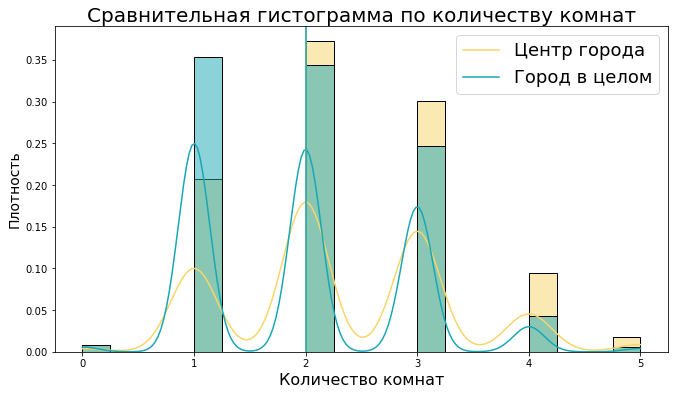

In [93]:
#SidebySideHist('rooms', 'rooms', 'Количество комнат', 'Количество наблюдений', 'Сравнительная гистограмма по количеству комнат')

SideBySideHist(
    data_center['rooms'], 
    data_spb['rooms'], 
    'Сравнительная гистограмма по количеству комнат',
    'Количество комнат', 
    ['Центр города', 'Город в целом']
    )

Бросается в глаза более равномерное распределение квартир в центре. Удельная доля квартир с 4-5 комнатами гораздо выше чем в целом по городу. Это подтверждает гипотезу, что жильё в центре - более разношерстное. А за центром - однотипное (1,2,3 комнаты).

Посмотрим на высоту потолков.

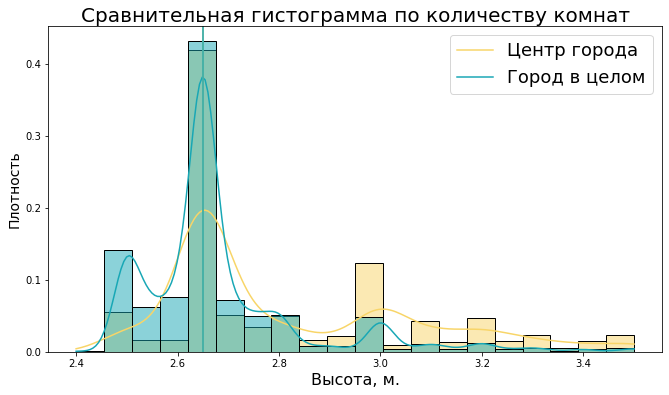

In [94]:
#SidebySideHist('ceiling_height', 'ceiling_height', 'Высота, м.', 'Количество наблюдений', 'Сравнительная гистограмма по высоте потолков')

SideBySideHist(
    data_center['ceiling_height'], 
    data_spb['ceiling_height'], 
    'Сравнительная гистограмма по количеству комнат',
    'Высота, м.', 
    ['Центр города', 'Город в целом']
    )

<div style="border:solid red 2px; padding: 20px"> <b>Что необходимо доработать</b><br>
Как же понять, что изображено на каждом графике? Предлагаю построить обе гистограммы на одной фигуре, можно добавить прозрачность или использовать только огибающую -   <a href="https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0">подсмотреть можно тут</a> или как минимум добавить легенду</div>

В среднем большинство значений находится в промежутке до 3м. Но в целом, другие значения в центре можно встретить гораздо чаще. Удельный вес их повыше.

Приходим к выводу, что в центре гораздо больше интересных/необычных предожений. И выбор (по приведенным параметрам) очень высок. В то время - как, дальше от центра - жилье становится более стандартизированным и однотипным. Одна высота потолка, определенное количество комнат, определенная площадь. 

Построим матрицу диаграм рассеяния для выборки всего города по параметрам число комнат, этаж, удалённость от центра, дата размещения объявления.
(у нас встречается небольшое количество неопределенных значений расстояния до центра - не будем их учитывать)

In [95]:
data_spb_new = data_spb[['rooms', 'floor', 'cityCenters_nearest', 'first_day_exposition', 'last_price']]

data_spb_new = data_spb_new[data_spb_new['cityCenters_nearest'] == data_spb_new['cityCenters_nearest']].reset_index(drop = True)

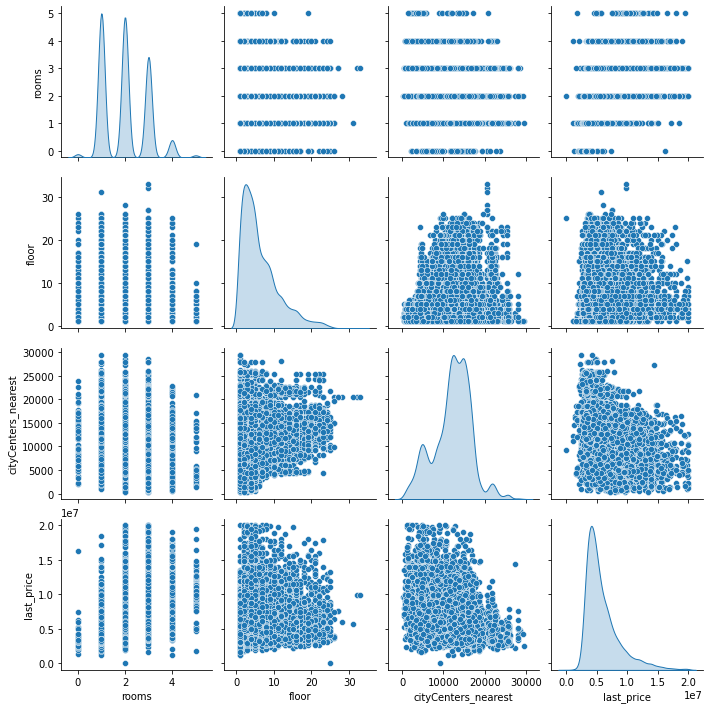

In [97]:
data_spb_new['rooms'] = data_spb_new['rooms'].astype('int')
data_spb_new['floor'] = data_spb_new['floor'].astype('int')
data_spb_new['last_price'] = data_spb_new['last_price'].astype('int')
data_spb_new['cityCenters_nearest'] = data_spb_new['cityCenters_nearest'].astype('int')

sns.pairplot(data_spb_new, diag_kind="kde");

Сделаем и подтвердим следующие выводы:

1) Чем больше комнат - тем выше цена

2) Первый этаж стоит заметно дешевле, чем все остальные

3) Чем ближе к центру - тем дороже квартиры

4) В центре (до 5 км) - преимущественно малоэтажная (5-этажная) застройка (по крайней мере таковы предложения)

### Шаг 5. Общий вывод

В нашем распоряжении оказались данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Данные на входе оказались сырыми и без предобработки не обошлось. По ряду параметров мы заметили совсем нереальные значения - например для высоты потолков. И заодно провели исследовательский анализ данных и избавились от нестандартных значений. В некоторых столбцах были замечены пропущенные значения. Так, для высоты потолков мы заменили их медианой. Для общего количества этажей приняли решение удалить данные - уж очень их было мало. Сведение апартаменты или нет - решили заполнить "нет", исходя из общих соображений. Если количество, балконов указано не было - решили, что скорее всего их нет вообще и заменили значение на 0. Для жилой площади - посчитали среднее соотношение жилой к общей и отталкиваясь от этого заменили пропущенные значения жилой площади. А вот с площадью кухни, мы пришли к выводу, что так не получится. Дом может быть огромным, но при этом кухня в нем будет не сильно отличаться от обычной и приняли решение заменить пропущенные значения средним арифметическим. По ряду других значений заполнять пропуски проблематичнее. В основном это картографические данные, а также "сколько дней было размещено объявление". Приняли решение оставить всё как есть - очень много значений отсутствует относительно общей выборки. По ряду атрибутов мы также изменили и тип данных. Апартаменты - да/нет - привели к bool. Картографические данные - количество водоемов/парков - это натуральные числа - к int. Картографические данные расстояния - за незначительностью дробной части решили от неё избавиться - к int. Аналогично и с ценой.

Некоторых параметров в изначальных данных не оказалось и кое-что нам пришлось вычислить и добавить. Например -цену квадратного метра; день недели, месяц и год публикации объявления; этаж квартиры (варианты — первый, последний, другой); соотношение жилой и общей площади, а также отношение площади кухни к общей.
Эти параметры мы будем использовать при дальнейшем анализе.

После чего - приступили к анализу параметров. Начали с площади. Таковы выводы:
Ожидаемо, получили пик в районе 30-40 и 40-50 кв.м. (дальше значения идут на спад). Логично отсутствие квартир до 10 кв.м. и совсем небольшое их количество в районе 10-20 кв.м. и 20-30 кв.м.(относительно). По гистограмме можно считать значения выше 130 - выбросами. Уж очень мало значений идёт в каждой корзине дальше.

По числу комнат получили следующий результат - Огромное количество наблюдений для 1, 2, 3 комнатных квартир. Гораздо меньше 4, 5 и 0 комнат. Остальные - очень редкие, выбивающиеся значения. Будем считать выбросами значения 6 и выше.

По высоте потолков вывод такой - подавляющее большинство значений находится в логичных рамках 2.4-3.5 м. А единичные выбросы - в большинстве своём начинаются от 3.5 и ниже 2,4 (единичные значения). 

По ценам ситуация такова - по гистограмме начиная с 2х10^7 график превращается в тонкую линию, которая потом и вовсе начинает прерываться. Определим нормальные значения до 2х10^7. 

По времени продажи квартиры сделали следующий вывод - если продажа прошла за 100 дней и менее - значит продажа прошла очень быстро, а выше 600 - очень долго.

Приняли решение - оставить только нормальные значения, а лишнее удалить. В итоге наши данные стали меньше на порядка 5 тыс наблюдений. (Количество записей до 23565. Количество записей после 18355)

Далее мы приступили к исследованию зависимостей параметров.

Оценили площадь - получили на графике этакое облако. Которое вытягивается "вверх и вправо", что означает, что с увеличением общей площади увеличивается и стоимость.

Цена зависит от количества комнат. С увеличением числа комнат "низ" шкалы на графике поднимается чуть выше (хорошо видно в сравнении 2 и 3 или 3 и 4). Точно так же и "верх" шкалы.

Проанализировали зависимость цены от расстояниядо центра - Снова получили на графике облако, которое вытягивается уже "вверх и влево", что означает, что чем ближе к центру - тем выше стоимость.

Проверили влияет ли первый/последний этаж на итоговую стоимость. Оказалось влияет - зависимость есть. И по медиане и по среднему. Так в среднем первые этажи дешевле на 15-20%. А последние - на 7-8. Относительно средних показателей.

Влияет ли год/месяц/день недели на стоимость - получили следующие выводы: в 2014-м году квартиры стоили гораздо дороже. После чего цены до сих пор остаются на +/- одном и том же уровне. Можно связать эту закономерность с падением курса рубля и соответствующим снижением уровня жизни. По месяцам - всё ровненько, никаких выбросов. Значения медианы в районе 4.2-4.5кк, ср.арифм. - 4.9-5.3кк. Аналогичная ситуация и по дням недели. Всё в пределах допустимой погрешности.

Выбрали 10 населённых пунктов с наибольшим числом объявлений. Из полученной нами выборки определили, что самое дорогое жильё - в Санкт-Петербурге, а самое дешевое в Выборге.

Приступили к изучению предложений из Санкт-Петербурга. Определили, что квартирами в центре города являются квартиры в радиусе 8 км.

Выделили отдельно центр Санкт-Петербурга и сравнили ключевые параметры с общей выборкой по городу. Получили интересные выводы:

В общем по городу преобладает группа 30-50 кв.м. Чуть поменьше - группа 50-70(80). В то время, как в центре, за исключением пика в районе 40-50, значения распределены +/- равномерно на промежутке от 30 и аж до 100 кв.м.

В центре немного смещен "пик" встречаемости цен. Если в общем по городу чаще всего можно встретить предложения 3-5 млн. То уже в центральной части - это значение 6-7 млн. Что подтверждает теорию о том, что чем ближе к центру тем дороже квартиры.

Удельная доля квартир с 4-5 комнатами гораздо выше чем в целом по городу.

Высота потолков - в среднем большинство значений находится в промежутке до 3м. Но в целом, другие значения в центре можно встретить гораздо чаще. Удельный вес их повыше.

Приходим к выводу, что в центре гораздо больше интересных/необычных предожений. И выбор (по приведенным параметрам) очень высок. В то время - как, дальше от центра - жилье становится более стандартизированным и однотипным. Одна высота потолка, определенное количество комнат, определенная площадь. 

Построили матрицу диаграм рассеяния для выборки всего города по параметрам число комнат, этаж, удалённость от центра.
По ней мы сделали и подтвердили следующие выводы:

1) Чем больше комнат - тем выше цена

2) Первый этаж стоит заметно дешевле, чем все остальные

3) Чем ближе к центру - тем дороже квартиры

4) В центре (до 5 км) - преимущественно малоэтажная (5-этажная) застройка (по крайней мере таковы предложения)



### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод